### Datasets used or mentioned in planfarm report from Pete

##### polygon of property boundary (probably also cadastral data)

##### SILO long term average temp and rainfall data over last 10 years
- SILO offers a web API, and accessing SILO datasets is free. there are a lot of them though, so some time needed to find the right ones
- https://www.longpaddock.qld.gov.au/silo/api-documentation/
- https://www.longpaddock.qld.gov.au/silo/about/data-products/ - landing page for point and gridded datasets
- also available on AWS - https://registry.opendata.aws/silo/
- data provided on daily/monthy scale, so I'd guess Planfarm use this to calculate the 10-year averages.
-  info and links for accessing gridded SILO data - https://www.longpaddock.qld.gov.au/silo/gridded-data/

##### 2023 monthly rainfall and temp data (s, current year or last 12 months)
- Likely also coming from SILO since it provides both daily and monthly summaries.
- Note SILO data is in NetCDF format (not a bad thing, just something we haven't work in before but its a common spatial format for climate data)

##### historical forest cover since 2018 indicating forest cover and woody biomass
- This is derived from the Dynamic World data (according to meeting with Jefferson in Nov 2023)
- https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1
- Data requires an earth engine cloud project. This will be annoying to figure out. Will mean having to manage GCP stuff.
- info on cloud projects and data implications: https://developers.google.com/earth-engine/guides/transition_to_cloud_projects

##### Aboriginal heritage sites (presumably govt data)/ native title
- https://www.nntt.gov.au/assistance/Geospatial/Pages/Spatial-aata.aspx
- direst file downloads. SO data access is easy but implementation into a notebook will need a little bit of work
- probably will need to find a way of staring a local copy that can be accessed in a notebook

##### DPIRD salinity extent dataset, indicates areas that are saline and indicates extent
- 2018 salinity extent available via a WFS
- https://public-services.slip.wa.gov.au/public/services/Land_Monitor/Land_Monitor/MapServer/WMSServer
- Can download data from the WFS and convert to geotiff in QGIS, should be able to do it in Python

##### soil depth - appears to be the DPIRD dataset but can be substituted with the GA one of needed
- rather than showing raw pixels this seems to have been reclassified. looks like Farmlab?

##### Topographical wetness index
- can be directly downloaded as a mosaic geotiff - it is 67GB in size.
- https://data.csiro.au/collection/csiro:5588v2
- Given how old it is (2015) it won't be a COG - so we could download it, process it into COG tiles and store it ourselves?
- My best guess is PlanFarm keep a local copy of this for use
- available in 1 arcsecond (30m) and 3 arcsecond (90m)

##### Elevation
- We have something similar to this through Copernicus global 30m DEM and Geoscience Australia DEM

In [ ]:
#%pip install netCDF4 -q
#%pip install lxml -q
#%pip install dask[distributed] -q
#%pip install intake -q
#%pip install fsspec -q
#%pip install utils -q
#%pip install aiohttp -q
#%pip install leafmap -q

In [37]:
from datetime import datetime
import utils
import requests
import aiohttp
import shutil
from io import StringIO
import json
import fsspec
import tempfile


import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from rasterio.plot import reshape_as_raster, show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.vrt import WarpedVRT

#import zarr
import netCDF4

import os

import sys
import dask

from IPython.display import display
import leafmap

import matplotlib.pyplot as plt
from dask.distributed import Client

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
dask.config.set(scheduler="threads")  # Use multithreading

### Area of interest

In [38]:
geojson = {
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
}

req = geojson
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

# get the boudning box from the geodataframe
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds

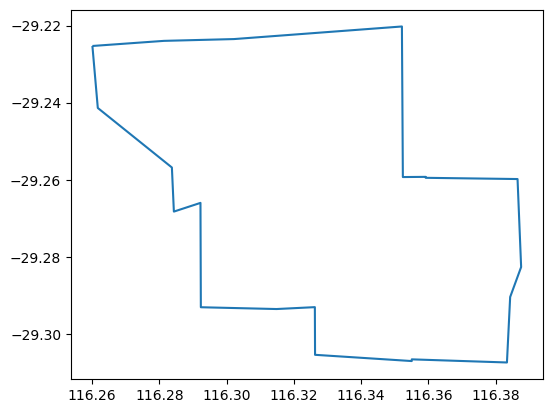

In [39]:
#show gdf on a map
ax = gdf.boundary.plot()

### SILO data

#### SILO variables:
- "daily_rain": "Daily rainfall, mm",
- "monthly_rain": "Monthly rainfall, mm",
- "max_temp": "Maximum temperature, degrees Celsius",
- "min_temp": "Minimum temperature, degrees Celsius",
- "vp": "Vapour pressure, hPa",
- "vp_deficit": "Vapour pressure deficit, hPa",
- "evap_pan": "Class A pan evaporation, mm",
- "evap_syn": "Synthetic estimate, mm",
- "evap_comb": "Combination: synthetic estimate pre-1970, class A pan 1970 onwards, mm",
- "evap_morton_lake": "Morton's shallow lake evaporation, mm",
- "radiation": "Solar radiation: Solar exposure, consisting of both direct and diffuse components, MJ/m2",
- "rh_tmax": "Relative humidity:	Relative humidity at the time of maximum temperature, %",
- "rh_tmin": "Relative humidity at the time of minimum temperature, %",
- "et_short_crop": "Evapotranspiration FAO564 short crop, mm",
- "et_tall_crop": "ASCE5 tall crop6, mm",
- "et_morton_actual": "Morton's areal actual evapotranspiration, mm",
- "et_morton_potential": "Morton's point potential evapotranspiration, mm",
- "et_morton_wet": "Morton's wet-environment areal potential evapotranspiration over land, mm",
- "mslp": "Mean sea level pressure Mean sea level pressure, hPa"

In [40]:
silo_baseurl = (
        "https://s3-ap-southeast-2.amazonaws.com/silo-open-data/Official/annual/"
    )

layernames = ["monthly_rain", "max_temp", "min_temp"]
years = [2019]

outpath = "/workspace/notebooks/sandbox/data/SILO"

In [41]:
datasets = {}

for layername in layernames:
    datasets[layername] = {}
    for year in years:
        url = silo_baseurl + layername + "/" + str(year) + "." + layername + ".nc"

        try:
            with fsspec.open(url) as remote_file:
                with tempfile.NamedTemporaryFile(suffix=".nc") as tmp_file:
                    tmp_file.write(remote_file.read())
                    tmp_file.flush()
                    ds = xr.open_dataset(tmp_file.name, engine="netcdf4", chunks="auto")

                    ds_subset = ds.sel( {"lat": slice(min_lat, max_lat), "lon": slice(min_lon, max_lon)})
            
            # Process the dataset as needed
            if year == years[0]:
                datasets[layername] = ds_subset
            else:
                datasets[layername] = xr.concat([datasets[layername], ds_subset], dim="time")
        
        except Exception as e:
            print(f"Failed to load dataset for {layername} in {year}. Error: {e}")

# Example: Inspect one dataset
print(datasets["monthly_rain"])

<xarray.Dataset> Size: 513B
Dimensions:       (lat: 2, lon: 2, time: 12)
Coordinates:
  * lat           (lat) float64 16B -29.3 -29.25
  * lon           (lon) float64 16B 116.3 116.3
  * time          (time) datetime64[ns] 96B 2019-01-16T12:00:00 ... 2019-12-1...
Data variables:
    monthly_rain  (time, lat, lon) float64 384B dask.array<chunksize=(3, 2, 2), meta=np.ndarray>
    crs           |S1 1B ...
Attributes:
    department:               Department of Environment and Science
    department_short:         DES
    copyright:                Copyright - the State of Queensland Department ...
    site_url:                 http://www.longpaddock.qld.gov.au
    institution:              Queensland Government, Department of Environmen...
    raster_source:            Gridded surface was created by interpolating ob...
    raster_source_additions:  and other suppliers (see the SILO webpage for d...
    metadata_url:             http://qldspatial.information.qld.gov.au/catalo...
    referen

In [42]:
# Initialize an empty dictionary to store data for the table
data_dict = {}

# Loop through the datasets and extract monthly data for rainfall and max_temp
for layername in layernames:
    if layername in datasets:
        if layername == "monthly_rain":
            # Extract monthly rainfall data
            monthly_rain = datasets[layername].to_dataframe().reset_index()
            monthly_rain.drop(columns=["lat", "lon", "crs"], inplace=True)
            monthly_rain.set_index("time", inplace=True)
            monthly_rain = monthly_rain.resample("ME").sum()
            data_dict["monthly_rain"] = monthly_rain
        if layername == "max_temp":
            # Extract monthly max temperature data
            max_temp = datasets[layername].to_dataframe().reset_index()
            max_temp.drop(columns=["lat", "lon", "crs"], inplace=True)
            max_temp.set_index("time", inplace=True)
            max_temp = max_temp.resample("ME").mean()
            data_dict["max_temp"] = max_temp
        if layername == "min_temp":
            # Extract monthly max temperature data
            max_temp = datasets[layername].to_dataframe().reset_index()
            max_temp.drop(columns=["lat", "lon", "crs"], inplace=True)
            max_temp.set_index("time", inplace=True)
            max_temp = max_temp.resample("ME").mean()
            data_dict["min_temp"] = max_temp

display(data_dict["monthly_rain"].T)
display(data_dict["max_temp"].T)
display(data_dict["min_temp"].T)


time,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31
monthly_rain,0.0,39.8,23.8,68.2,4.2,371.4,129.6,73.8,18.5,21.3,0.2,0.5


time,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31
max_temp,37.695161,38.449107,35.231452,28.971667,24.352419,19.279167,19.660484,21.442742,26.895,29.695161,35.421667,38.827419


time,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31
min_temp,18.029839,19.433929,19.379032,13.818333,8.247581,7.558333,5.735484,6.159677,9.015,11.833065,15.8075,19.199194


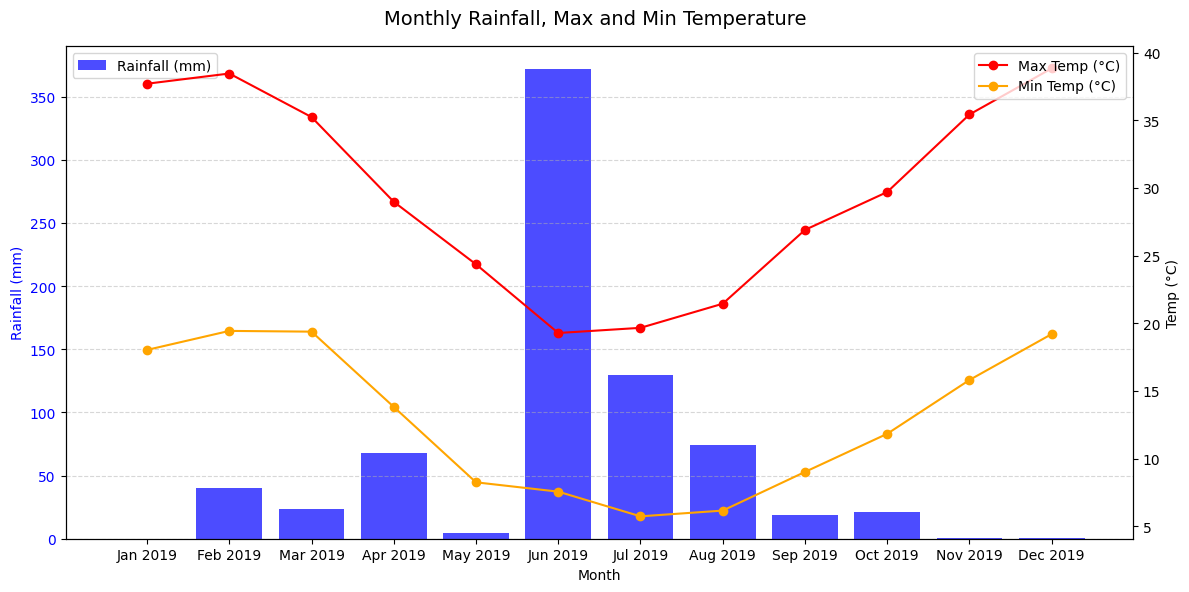

In [43]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

months = data_dict["monthly_rain"].index.strftime("%b %Y")
max_tmp = data_dict["max_temp"]["max_temp"].values
min_tmp = data_dict["min_temp"]["min_temp"].values
sum_rain = data_dict["monthly_rain"]["monthly_rain"].values

# Plot Rainfall (on the left y-axis)
ax1.bar(months, sum_rain, color="blue", alpha=0.7, label="Rainfall (mm)")
ax1.set_xlabel("Month")
ax1.set_ylabel("Rainfall (mm)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Plot Max Temp and Min Temp (on the right y-axis)
ax2 = ax1.twinx()
ax2.plot(months, max_tmp, color="red", marker="o", label="Max Temp (°C)")
ax2.plot(months, min_tmp, color="orange", marker="o", label="Min Temp (°C)")
ax2.set_ylabel("Temp (°C)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Add grid, title, and legend
ax1.grid(axis="y", linestyle="--", alpha=0.5)
fig.suptitle("Monthly Rainfall, Max and Min Temperature", fontsize=14)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Soil Depth (SLGA)

- "layer_name": "Depth_of_Regolith",
- "title": "Depth of Regolith",
- "si_unit": "m",
- "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/DES/DES_000_200_EV_N_P_AU_TRN_C_20190901.tif"


In [53]:
soil_depth_cog_url = "https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/DES/DES_000_200_EV_N_P_AU_TRN_C_20190901.tif"


In [54]:
with rasterio.open(soil_depth_cog_url) as soil_src:
    gdf_window = gdf.to_crs(soil_src.crs)
    bounds_window = gdf_window.total_bounds
    window = from_bounds(bounds_window[0], bounds_window[1], bounds_window[2], bounds_window[3], soil_src.transform)
    soil_cog_data = soil_src.read(1, window=window)
    transform = soil_src.window_transform(window)
    raster_crs = soil_src.crs

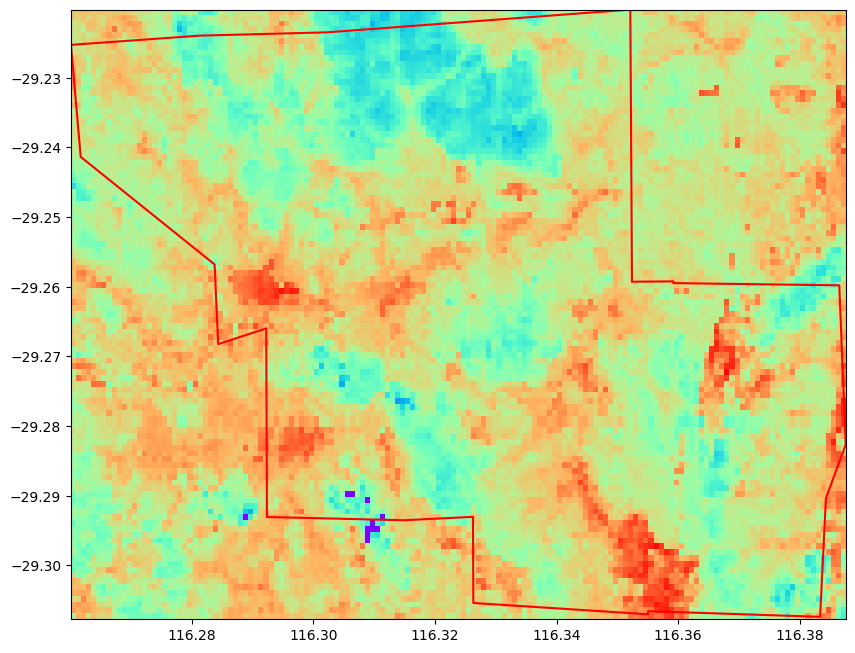

In [55]:

soil_filename = os.path.join(outpath, "soil_depth.tif")
with rasterio.open(soil_filename, "w", driver="GTiff", height=soil_cog_data.shape[0], width=soil_cog_data.shape[1], count=1, dtype=soil_cog_data.dtype, crs=raster_crs, transform=transform) as soil_dst:
    soil_dst.write(soil_cog_data, 1)

# now open the geotiff and plot it
with rasterio.open(soil_filename) as soil_src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(soil_src, ax=ax, cmap="rainbow")
    gdf.boundary.plot(ax=ax, color="red")
    plt.show()

### Elevation

- 'https://dea-public-data.s3-ap-southeast-2.amazonaws.com/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif'

In [56]:
dem_cog_url = 'https://dea-public-data.s3-ap-southeast-2.amazonaws.com/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif'

In [57]:
with rasterio.open(dem_cog_url) as dem_src:
    gdf_window = gdf.to_crs(dem_src.crs)
    bounds_window = gdf_window.total_bounds
    window = from_bounds(bounds_window[0], bounds_window[1], bounds_window[2], bounds_window[3], dem_src.transform)
    dem_cog_data = dem_src.read(1, window=window)
    transform = dem_src.window_transform(window)
    raster_crs = dem_src.crs

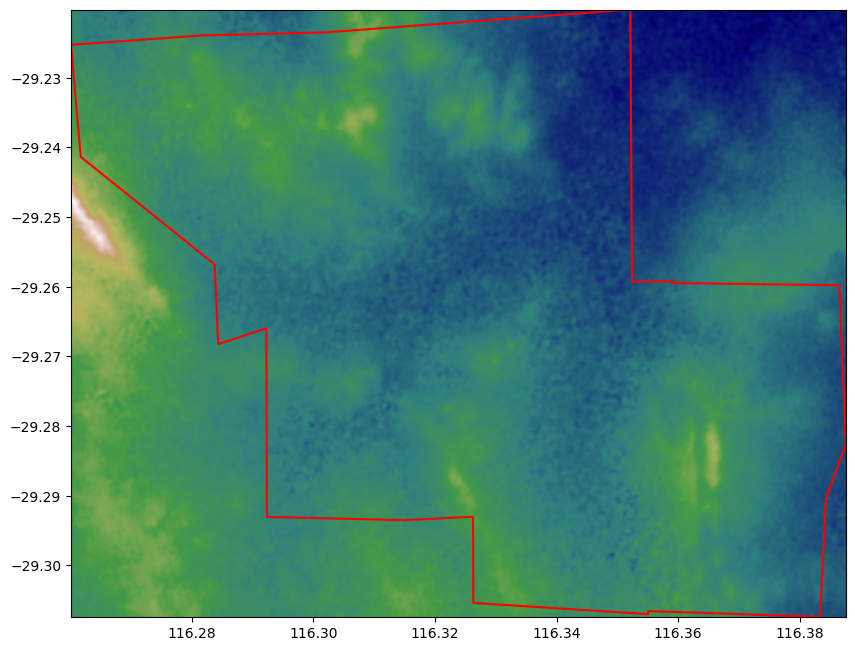

In [58]:

dem_filename = os.path.join(outpath, "elevation.tif")
with rasterio.open(dem_filename, "w", driver="GTiff", height=dem_cog_data.shape[0], width=dem_cog_data.shape[1], count=1, dtype=dem_cog_data.dtype, crs=raster_crs, transform=transform) as dem_dst:
    dem_dst.write(dem_cog_data, 1)

# now open the geotiff and plot it
with rasterio.open(dem_filename) as dem_src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(dem_src, ax=ax, cmap="gist_earth")
    gdf.boundary.plot(ax=ax, color="red")
    plt.show()